# Removing the outer ring of dermascopic images

This notebook outlines a method to remove the outer ring of the dermascope from images with it present in order to better mask the image

Images without this circle should not be affected as the image outline will count as the largest contour

This is an issue when the lesion is not centred and is off the edge of the image

----

## Standard Imports

In [1]:
# append custom system path for custom modules folder in directory if not already
import sys
if  '../../Modules' not in sys.path:
    sys.path.insert(0, '../../Modules')

import pandas as pd
import numpy as np
from PIL import Image
import os, os.path
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.utils import Bunch
import cv2 as cv
import image_modifications as im # custom image modification module
import isic_data as isic

----

## Load Dataset Into Memory

In [2]:
X = isic.get_data(type = 'none')

lesions_train = X[0]
lesions_test = X[1]

----

## Example Image To Highlight Problem

As seen below, this image has a large black background where the edges of the dermascope lay

When creating a mask for this image, there is a blue circle around the image

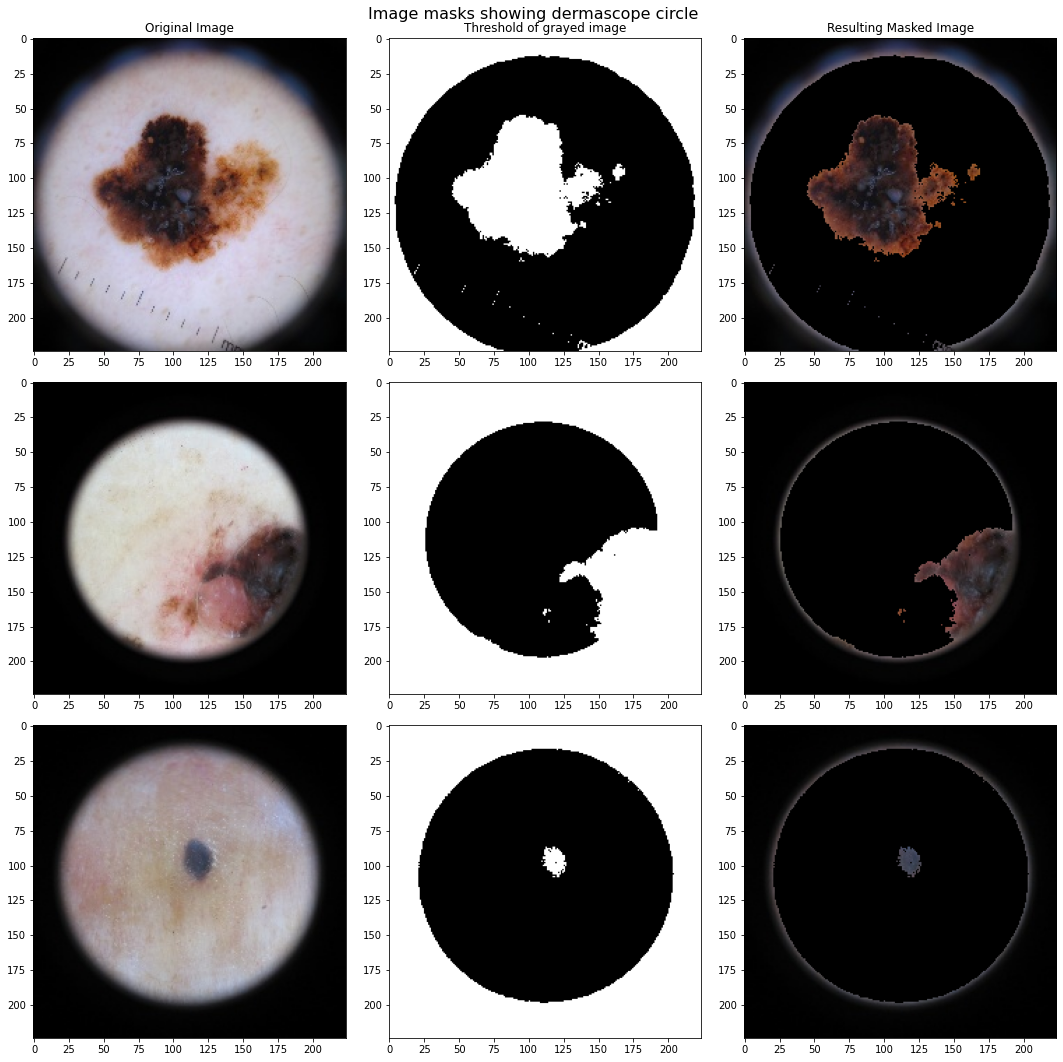

In [3]:
image = np.copy(lesions_train.images[5]) # 5, 50, 200, 227, 237, 238, breaks 250,
image_gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
image_thresh = cv.threshold(image_gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]
image_result = cv.bitwise_and(image, image, mask = image_thresh)

image_two = np.copy(lesions_train.images[227])
image_two_gray = cv.cvtColor(image_two, cv.COLOR_RGB2GRAY)
image_two_thresh = cv.threshold(image_two_gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]
image_two_result = cv.bitwise_and(image_two, image_two, mask = image_two_thresh)

image_three = np.copy(lesions_train.images[238])
image_three_gray = cv.cvtColor(image_three, cv.COLOR_RGB2GRAY)
image_three_thresh = cv.threshold(image_three_gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]
image_three_result = cv.bitwise_and(image_three, image_three, mask = image_three_thresh)

fig, axes = plt.subplots(3, 3, figsize = (15,15))
axes[0][0].imshow(image)
axes[0][0].title.set_text("Original Image")
axes[0][1].imshow(image_thresh, cmap = 'gray')
axes[0][1].title.set_text("Threshold of grayed image")
axes[0][2].imshow(image_result)
axes[0][2].title.set_text("Resulting Masked Image")

axes[1][0].imshow(image_two)
axes[1][1].imshow(image_two_thresh, cmap = 'gray')
axes[1][2].imshow(image_two_result)

axes[2][0].imshow(image_three)
axes[2][1].imshow(image_three_thresh, cmap = 'gray')
axes[2][2].imshow(image_three_result)


fig.suptitle("Image masks showing dermascope circle", fontsize=16)
fig.tight_layout();

----------------------
-----------------------
# Below is a great start to masking the images

## This should only be done when the images have DCA's on them
----------------------
----------------------

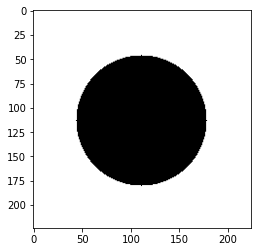

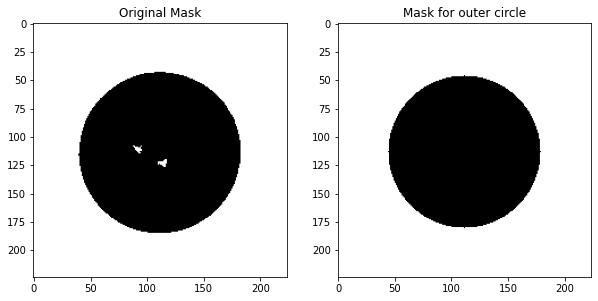

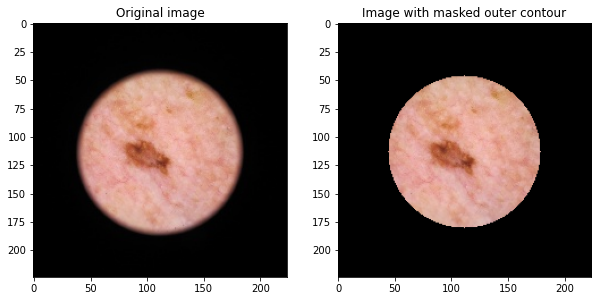

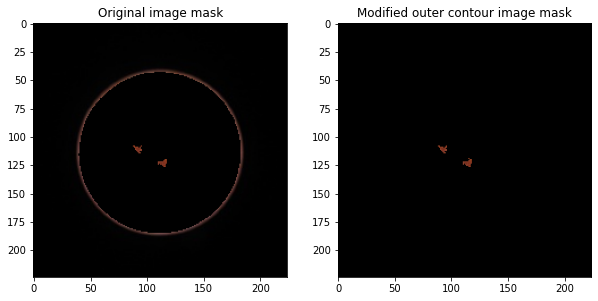

In [4]:
test_image = np.copy(lesions_train.images[667]) #233 #239 #636 #679 #677 #676
test_image_gray = cv.cvtColor(test_image, cv.COLOR_RGB2GRAY)
test_image_thresh = cv.threshold(test_image_gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]
test_image_result = cv.bitwise_and(test_image, test_image, mask = test_image_thresh)


image_thresh = 100
ret,thresh_img = cv.threshold(test_image_gray, image_thresh, 255, cv.THRESH_BINARY)



contours, hierarchy = cv.findContours(thresh_img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
img_contours = np.zeros(image.shape)
#plt.imshow((cv.drawContours(img_contours, contours, -1, (0,255,0), 3)).astype(np.uint8));


###
# FIND THE LARGEST CONTOUR FROM LIST OF CONTOURS & CREATE MASK
###
contours,hierarchy = cv.findContours(thresh_img,2,1)
cnt = contours
contoursB = []
big_contour = []
max = 0
for i in cnt:
    area = cv.contourArea(i) #--- find the contour having biggest area ---
    if(area > max):
        max = area
        big_contour = i 
        contoursB.append(i)
        
(xx,yy), radius = cv.minEnclosingCircle(big_contour)
center = (int(xx), int(yy))
radius = int(radius) - 4
this_contour = cv.circle(np.ones(test_image_gray.shape),center,radius,(0,255,0),-1)
plt.imshow(this_contour, cmap = 'gray')

###
# DISPLAY MASKS
###
fig, axes = plt.subplots(1,2, figsize = (10,10))

axes[0].imshow(cv.threshold(test_image_gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1], cmap='gray')
axes[0].title.set_text("Original Mask")
axes[1].imshow(this_contour, cmap='gray')
axes[1].title.set_text("Mask for outer circle")

###
# DISPLAY ORIGINAL IMAGES
###
fig, axes = plt.subplots(1,2, figsize=(10,10))

output = test_image.copy()
output[this_contour.astype(np.bool)] = 0

axes[0].imshow(test_image)
axes[0].title.set_text("Original image")
axes[1].imshow(output)
axes[1].title.set_text("Image with masked outer contour");

###
# DISPLAY MASKED IMAGES
###
fig,axes = plt.subplots(1,2, figsize=(10,10))
axes[0].imshow(test_image_result)
axes[0].title.set_text("Original image mask")

output_gray = cv.cvtColor(output, cv.COLOR_RGB2GRAY)
output_thresh = cv.threshold(output_gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]

output_result = cv.bitwise_and(output, output, mask = output_thresh)
axes[1].imshow(output_result)
axes[1].title.set_text("Modified outer contour image mask");

--------------------

-------------------

--------------------

----

## Find the largest contour

In order to remove this, it is necessary to find the outer circle before masking the image.

In this instance, the largest contour will be the outer circle, as shown below

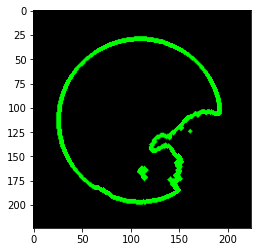

In [5]:
image_thresh = 100
ret,thresh_img = cv.threshold(image_two_gray, image_thresh, 255, cv.THRESH_BINARY)
contours, hierarchy = cv.findContours(thresh_img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
img_contours = np.zeros(image.shape)
plt.imshow((cv.drawContours(img_contours, contours, -1, (0,255,0), 3)).astype(np.uint8));

In [6]:
#(xx,yy), radius = cv.minEnclosingCircle()

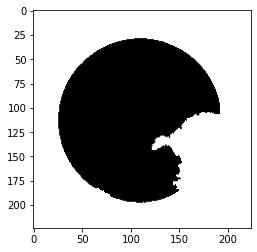

In [7]:
###
# FIND THE LARGEST CONTOUR FROM LIST OF CONTOURS & CREATE MASK
###
contours,hierarchy = cv.findContours(thresh_img,2,1)
cnt = contours
contoursB = []
big_contour = []
max = 0
for i in cnt:
    area = cv.contourArea(i) #--- find the contour having biggest area ---
    if(area > max):
        max = area
        big_contour = i 
        contoursB.append(i)
        
# Simple binary threshold
_, image_gray = cv.threshold(image_gray, 128, 255, cv.THRESH_BINARY)

# Find contours
cnts, _ = cv.findContours(image_gray, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)

# Generate mask
mask = np.ones(image_gray.shape)
mask = cv.drawContours(mask, contoursB, -1, 0, cv.FILLED)
#final = cv.drawContours(image, big_contour, -1, (0,255,0), 3)
#plt.imshow(cv.drawContours(image, big_contour, -1, (0,255,0), 3))
plt.imshow(mask, cmap = 'gray');

In [8]:
(xx,yy), radius = cv.minEnclosingCircle(big_contour)
center = (int(xx), int(yy))
radius = int(radius) - 2
this_contour = cv.circle(np.ones(image_gray.shape),center,radius,(0,255,0),-1)

#these_contours = []
#these_contours.append(np.array(this_contour))
#this_mask = np.ones(image_gray.shape)
#this_mask = cv.drawContours(this_mask, this_contour, -1,0,cv.FILLED)
#plt.imshow(mask, cmap='gray')
#type(these_contours)

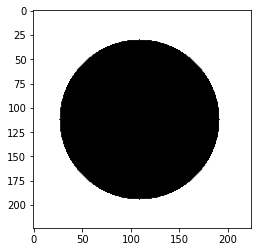

In [9]:
plt.imshow(this_contour, cmap = 'gray')

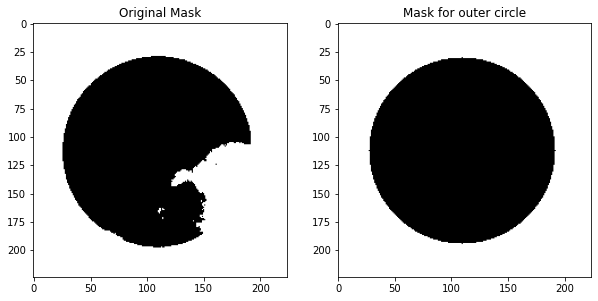

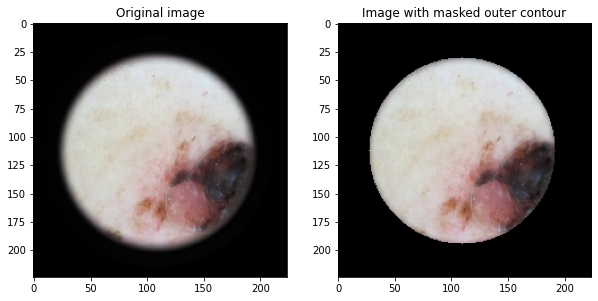

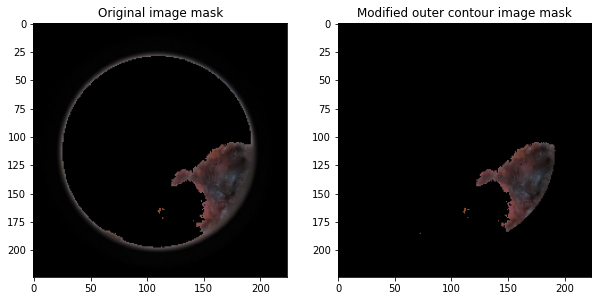

In [10]:
###
# DISPLAY MASKS
###
fig, axes = plt.subplots(1,2, figsize = (10,10))

axes[0].imshow(cv.threshold(image_two_gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1], cmap='gray')
axes[0].title.set_text("Original Mask")
axes[1].imshow(this_contour, cmap='gray')
axes[1].title.set_text("Mask for outer circle")

###
# DISPLAY ORIGINAL IMAGES
###
fig, axes = plt.subplots(1,2, figsize=(10,10))

output = image_two.copy()
output[this_contour.astype(np.bool)] = 0

axes[0].imshow(image_two)
axes[0].title.set_text("Original image")
axes[1].imshow(output)
axes[1].title.set_text("Image with masked outer contour");

###
# DISPLAY MASKED IMAGES
###
fig,axes = plt.subplots(1,2, figsize=(10,10))
axes[0].imshow(image_two_result)
axes[0].title.set_text("Original image mask")

output_gray = cv.cvtColor(output, cv.COLOR_RGB2GRAY)
output_thresh = cv.threshold(output_gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]

output_result = cv.bitwise_and(output, output, mask = output_thresh)
axes[1].imshow(output_result)
axes[1].title.set_text("Modified outer contour image mask");

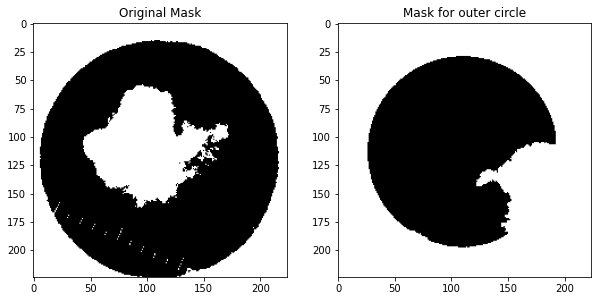

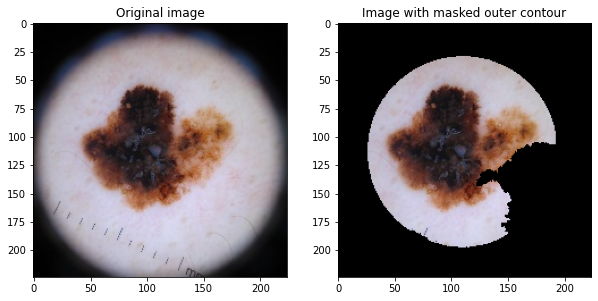

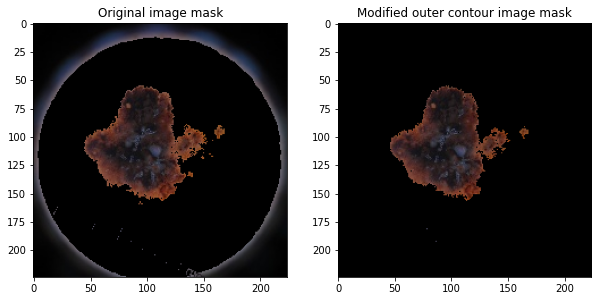

In [11]:
###
# DISPLAY MASKS
###
fig, axes = plt.subplots(1,2, figsize = (10,10))

axes[0].imshow(cv.threshold(image_gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1], cmap='gray')
axes[0].title.set_text("Original Mask")
axes[1].imshow(mask, cmap='gray')
axes[1].title.set_text("Mask for outer circle")

###
# DISPLAY ORIGINAL IMAGES
###
fig, axes = plt.subplots(1,2, figsize=(10,10))

output = image.copy()
output[mask.astype(np.bool)] = 0

axes[0].imshow(image)
axes[0].title.set_text("Original image")
axes[1].imshow(output)
axes[1].title.set_text("Image with masked outer contour");

###
# DISPLAY MASKED IMAGES
###
fig,axes = plt.subplots(1,2, figsize=(10,10))
axes[0].imshow(image_result)
axes[0].title.set_text("Original image mask")

output_gray = cv.cvtColor(output, cv.COLOR_RGB2GRAY)
output_thresh = cv.threshold(output_gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]

output_result = cv.bitwise_and(output, output, mask = output_thresh)
axes[1].imshow(output_result)
axes[1].title.set_text("Modified outer contour image mask");